In [1]:
# BREAST CANCER CAUSES AND DRUG PREDICTION

# The program analyzes the cause of breast cancer from a Boolean network datamodel,
# namely which genes should be mutated to cause cancer and are they oncogenes (True) or tumor suppressors (False).
# Next, the program found the potential therapeutic targets and the actions on them for a cancer caused by  BRCA1 mutation.
import time
import matplotlib.pyplot as plt
from sympy import SOPform, simplify_logic
from tabulate import tabulate
from boon import *

In [2]:
# Import the breath cancer model from a Bool Net format file.
bcn = BooN.from_textfile("breast-cancer")

In [3]:
# Show the Boolean network
print(" - Boolean Network - ")
print(bcn)

 - Boolean Network - 
ERK12 = EGFR
PTEN = p53
PARP1 = ERK12
EGFR = ¬BRCA1
Bcl2 = Akt
Bax = p53 ∧ ¬Bcl2
Akt = PIK3CA
PIK3CA = EGFR ∧ ¬PTEN
CycD1 = (ERK12 ∧ ¬GSK3) ∨ (PARP1 ∧ ¬BRCA1)
MDM2 = Akt ∧ p53
GSK3 = ¬Akt
p53 = ¬MDM2 ∧ (BRCA1 ∨ ¬PARP1)
BRCA1 = ¬CycD1


In [4]:
# print all the genes.
print("\n", "List of genes: ", bcn.variables)


 List of genes:  {ERK12, PTEN, PARP1, EGFR, Bcl2, Bax, Akt, PIK3CA, CycD1, MDM2, GSK3, p53, BRCA1}


In [5]:
# Compute the stable states.
print("\n" * 2, " - Stable States -")
stable_states = bcn.stable_states
print(tabulate(stable_states, headers='keys', tablefmt='plain'))



  - Stable States -
CycD1    PARP1    PIK3CA    PTEN    GSK3    Bax    EGFR    Akt    Bcl2    BRCA1    MDM2    p53    ERK12
False    False    False     True    True    True   False   False  False   True     False   True   False
True     True     True      False   False   False  True    True   True    False    False   False  True


In [6]:
# *** Controllability analysis
# Define the biomarkers
CycD1, Bax = symbols("CycD1 Bax")
biomarkers = {CycD1, Bax}

# Characterize a marking corresponding to the apoptosis
marking = {CycD1: False, Bax: True}
print("Apoptosis biomarkers")
print(tabulate([marking], headers='keys', tablefmt='plain'))

Apoptosis biomarkers
CycD1    Bax
False    True


In [7]:
# convert the marking into a formula
apoptosis_marking = SOPform(biomarkers, [marking])

# Set the marking formula of cancer forbidding the apoptosis, that is the negation of apoptosis query, A cell therefore cannot die defining a hallmark of cancer. 
kquery = simplify_logic(~apoptosis_marking, force=True)

print("Disease query, prevent apoptosis: ", kquery)

Disease query, prevent apoptosis:  CycD1 | ~Bax


In [8]:
# Define the variables where the control can be applied to force the variable to True (1) or False (0).
# A variable can have both controls.
# The biomarkers are always excluded from the control since they are observers and cannot be directly controlled.
frozenvars0 = frozenvars1 = bcn.variables - biomarkers
print("Frozen variables")
print(tabulate([frozenvars0, frozenvars1], tablefmt='grid'))

Frozen variables
+-------+------+-------+------+------+-----+--------+------+------+-----+-------+
| ERK12 | PTEN | PARP1 | EGFR | Bcl2 | Akt | PIK3CA | MDM2 | GSK3 | p53 | BRCA1 |
+-------+------+-------+------+------+-----+--------+------+------+-----+-------+
| ERK12 | PTEN | PARP1 | EGFR | Bcl2 | Akt | PIK3CA | MDM2 | GSK3 | p53 | BRCA1 |
+-------+------+-------+------+------+-----+--------+------+------+-----+-------+


In [9]:
# Copy the network and fix the control on it. The control consists in adding control parameters (_u0<var>, _u1<var>) to formulas. 
bcc = bcn.copy()
bcc.control(frozenvars0, frozenvars1)

print("\n- Controlled Network -")
print(bcc)

# Specification of the query that the biological network necessary reach whatever the stable state.
# The necessity stipulates that all the stable stables must meet the query.


- Controlled Network -
ERK12 = ¬_u1ERK12 ∨ (EGFR ∧ _u0ERK12)
PTEN = ¬_u1PTEN ∨ (_u0PTEN ∧ p53)
PARP1 = ¬_u1PARP1 ∨ (ERK12 ∧ _u0PARP1)
EGFR = ¬_u1EGFR ∨ (_u0EGFR ∧ ¬BRCA1)
Bcl2 = ¬_u1Bcl2 ∨ (Akt ∧ _u0Bcl2)
Bax = p53 ∧ ¬Bcl2
Akt = ¬_u1Akt ∨ (PIK3CA ∧ _u0Akt)
PIK3CA = ¬_u1PIK3CA ∨ (EGFR ∧ _u0PIK3CA ∧ ¬PTEN)
CycD1 = (ERK12 ∧ ¬GSK3) ∨ (PARP1 ∧ ¬BRCA1)
MDM2 = ¬_u1MDM2 ∨ (Akt ∧ _u0MDM2 ∧ p53)
GSK3 = ¬_u1GSK3 ∨ (_u0GSK3 ∧ ¬Akt)
p53 = ¬_u1p53 ∨ (_u0p53 ∧ ¬MDM2 ∧ (BRCA1 ∨ ¬PARP1))
BRCA1 = ¬_u1BRCA1 ∨ (_u0BRCA1 ∧ ¬CycD1)


In [10]:
print("\nQuery: Necessary avoid the apoptosis.")
print("/!\\ Around 3500 models are scanned. Be patient please.")
start_time = time.time()
destiny = bcc.necessary(kquery, trace=True)  # activate the trace to see the evolution of the computation.
print("Runtime..: {:5.2f}".format(time.time() - start_time))
print("# clauses: {}".format(len(destiny.args)))
print("# symbols: {}".format(destiny.count(Symbol)))


Query: Necessary avoid the apoptosis.
/!\ Around 3500 models are scanned. Be patient please.
BooN >> # models:[ 3451]
BooN >> CNF formatting: 100% |██████████████████████[3451  - 00:19 - 175.78it/s]
Runtime..: 112.16
# clauses: 3451
# symbols: 53484


In [11]:
print("\nCore")
print("About 10 solutions.")
# Compute the core.
start_time = time.time()
core = BooN.destify(destiny, trace=True)
print("Runtime: {:5.2f}".format(time.time() - start_time))


Core
About 10 solutions.
BooN >> # solutions:[  9]                      
Runtime: 13.30


In [12]:
print("\nActions")  # Transform the core into actions.
actions = core2actions(core)
print(tabulate(actions))


Actions
--------------  -------------
(MDM2, True)
(Bcl2, True)
(p53, False)
(BRCA1, False)
(Akt, True)
(PIK3CA, True)
(GSK3, False)   (ERK12, True)
(EGFR, True)    (GSK3, False)
(EGFR, True)    (PTEN, False)
--------------  -------------


In [13]:
# We define a situation of cancer with BRCA1 mutation.
print("\n" * 2, " - Mutate BRCA1  -")
BRCA1 = symbols("BRCA1")
bcn.desc[BRCA1] = False

print("Mutated network.")
print(bcn)



  - Mutate BRCA1  -
Mutated network.
ERK12 = EGFR
PTEN = p53
PARP1 = ERK12
EGFR = ¬BRCA1
Bcl2 = Akt
Bax = p53 ∧ ¬Bcl2
Akt = PIK3CA
PIK3CA = EGFR ∧ ¬PTEN
CycD1 = (ERK12 ∧ ¬GSK3) ∨ (PARP1 ∧ ¬BRCA1)
MDM2 = Akt ∧ p53
GSK3 = ¬Akt
p53 = ¬MDM2 ∧ (BRCA1 ∨ ¬PARP1)
BRCA1 = false


In [14]:
# copy the network and apply control
# Remove the mutated gene from the controlled variable since no modifications is possible.
frozenvars0 = frozenvars1 = frozenvars0 - {BRCA1}
bndrug = bcn.copy()  # fix control on a new instance of bcn.
bndrug.control(frozenvars0, frozenvars1)

In [15]:
# The issue is now to possibly find the actions inducing the apoptosis to deduce the therapeutic targets.
# The possibility stipulates that at least a stable state fulfills the query property.
# the possibility operation is faster to generate than the necessity.
print("\nQuery : Possibly lead to apoptosis.")

start_time = time.time()
destiny = bndrug.possibly(apoptosis_marking)
print("Runtime..: {:5.2f}".format(time.time() - start_time))
print("# clauses: {}".format(len(destiny.args)))
print("# symbols: {}".format(destiny.count(Symbol)))


Query : Possibly lead to apoptosis.
Runtime..:  0.01
# clauses: 15
# symbols: 55


In [16]:
print("\nCore")
start_time = time.time()
core = BooN.destify(destiny)
print("Runtime: {:5.2f}".format(time.time() - start_time))


Core
Runtime:  0.56


In [17]:
print("\nActions")  # Transform the core into actions.
actions = core2actions(core)
print(tabulate(actions))


Actions
--------------
(EGFR, False)
(PARP1, False)
(ERK12, False)
--------------


Interaction Graph


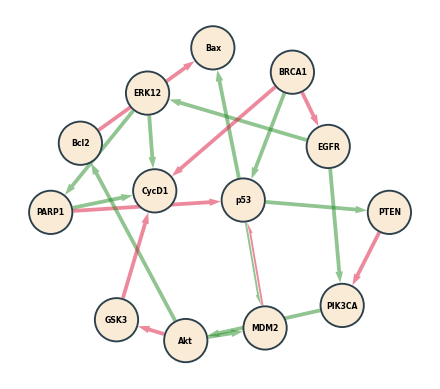

In [18]:
print("Interaction Graph")
# interaction graph
bcn.draw_IG()
plt.show()  # Show the interaction graph